In [79]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semid/outlets_data.csv
/kaggle/input/semid/product_data.csv
/kaggle/input/semid/freezer_data.csv
/kaggle/input/semid/week_data.csv
/kaggle/input/semid/sales_data.csv
/kaggle/input/finaldataset/outlets_data.csv
/kaggle/input/finaldataset/Data-dictionary.xlsx
/kaggle/input/finaldataset/product_data.csv
/kaggle/input/finaldataset/freezer_data.csv
/kaggle/input/finaldataset/week_data.csv
/kaggle/input/finaldataset/sales_data.csv


In [80]:
outlets_data = pd.read_csv('/kaggle/input/semid/outlets_data.csv')
product_data = pd.read_csv('/kaggle/input/finaldataset/product_data.csv')
freezer_data = pd.read_csv('/kaggle/input/semid/freezer_data.csv')
week_data = pd.read_csv('/kaggle/input/semid/week_data.csv')
sales_data = pd.read_csv('/kaggle/input/semid/sales_data.csv')

We remove the multiple records of the same outlet and take the mean area and assign it the given outlet

In [81]:
# Group the data by Outlet_ID and calculate the mean of the area column for each Outlet_ID
outlet_data_agg = outlets_data.groupby('Outlet_ID').agg({'area(sqft)': 'mean'}).reset_index()

# Display the resulting table
outlet_data_agg.head()

outlets_data = outlet_data_agg

In [82]:
outlets_data.head()

,Outlet_ID,area(sqft)
0,ID1008,3387.0
1,ID1012,1931.0
2,ID1024,3127.0
3,ID1029,5294.0
4,ID1036,2584.0


In [83]:
sales_data.head()

,Outlet_ID,week,pid,product_name,no_units
0,ID7203,1,IP1,Vanilla Mini Cone,874.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0


Adding the new feature avg_weekly_sales feature to the table outlets_data

In [84]:
# calculate the total sales for each Outlet_ID
total_sales = sales_data.groupby('Outlet_ID')['no_units'].sum()

# calculate the number of weeks for each Outlet_ID
num_weeks = sales_data.groupby('Outlet_ID')['week'].nunique()

# calculate the average weekly total sales for each Outlet_ID
avg_weekly_sales = total_sales / num_weeks

# create a new column in outlets_data for the average weekly total sales
outlets_data['avg_weekly_sales'] = avg_weekly_sales.reindex(outlets_data['Outlet_ID']).values

outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales
0,ID1008,3387.0,2750.166667
1,ID1012,1931.0,272.916667
2,ID1024,3127.0,578.583333
3,ID1029,5294.0,4095.166667
4,ID1036,2584.0,2613.666667


Adding two new features avg_weekly_volume_0.2 and avg_weekly_volume_1. avg_weekly_volume_0.2 represents the average volume the items which has 0.2L takes in the given outlet in a week. avg_weekly_volume_1 represents the average volume the items which has 1L rakes in the given outlet in a week.

In [85]:
# Merge the sales_data and product_data dataframes
merged_df = pd.merge(sales_data, product_data, on='pid')

# Calculate the total volume sold for each week for each outlet
merged_df['total_volume'] = merged_df['no_units'] * merged_df['volume']

# Group by week, Outlet_ID, and volume to get the total volume sold for each week for each outlet and volume
grouped_df = merged_df.groupby(['week', 'Outlet_ID', 'volume'])['total_volume'].sum().reset_index()

# Calculate the average weekly volume sold for each outlet and volume
avg_weekly_volume = grouped_df.groupby(['Outlet_ID', 'volume'])['total_volume'].mean().reset_index()

# Pivot the avg_weekly_volume dataframe to get one row per Outlet_ID and one column per volume
avg_weekly_volume_pivot = avg_weekly_volume.pivot(index='Outlet_ID', columns='volume', values='total_volume').reset_index()

# Rename the columns
avg_weekly_volume_pivot.columns = ['Outlet_ID', 'avg_weekly_volume_0.2', 'avg_weekly_volume_1']

# Merge the avg_weekly_volume_pivot dataframe with the outlets_data dataframe
outlets_data = pd.merge(outlets_data, avg_weekly_volume_pivot, on='Outlet_ID', how='left')
outlets_data.fillna(0, inplace=True)
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1
0,ID1008,3387.0,2750.166667,550.033333,0.000000
1,ID1012,1931.0,272.916667,0.000000,272.916667
2,ID1024,3127.0,578.583333,0.000000,578.583333
3,ID1029,5294.0,4095.166667,679.666667,696.833333
4,ID1036,2584.0,2613.666667,470.050000,263.416667


Adding the avg_weekly_volume feature. It calculates the average weekly volume that has been sold for a given outlet.

In [86]:
# Merge the sales_data and product_data dataframes
merged_df = pd.merge(sales_data, product_data, on='pid')

# Calculate the total volume sold for each week for each outlet
merged_df['total_volume'] = merged_df['no_units'] * merged_df['volume']

# Group by week and Outlet_ID to get the total volume sold for each week for each outlet
grouped_df = merged_df.groupby(['week', 'Outlet_ID'])['total_volume'].sum().reset_index()

# Calculate the average weekly volume sold for each outlet
avg_weekly_volume = grouped_df.groupby('Outlet_ID')['total_volume'].mean().reset_index()

# Add the average weekly volume sold as a new column in the outlets_data dataframe
outlets_data = pd.merge(outlets_data, avg_weekly_volume, on='Outlet_ID', how='left')
outlets_data.rename(columns={'total_volume': 'avg_weekly_volume'}, inplace=True)
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667


Adding two features avg_weekly_income_0.2 and avg_weekly_income_1. avg_weekly_income_0.2 calculate the average weekly income for each oultlet and for the items with 0.2L. avg_weekly_income_1 calculate the average weekly income for each outlet and for the items with 1L capacity.

In [87]:
# Merge the sales_data and product_data dataframes
merged_df = pd.merge(sales_data, product_data, on='pid')

# Calculate the total income for each week for each outlet
merged_df['total_income'] = merged_df['no_units'] * merged_df['price']

# Group by week, Outlet_ID, and volume to get the total income for each week for each outlet and volume
grouped_df = merged_df.groupby(['week', 'Outlet_ID', 'volume'])['total_income'].sum().reset_index()

# Calculate the average weekly income for each outlet and volume
avg_weekly_income = grouped_df.groupby(['Outlet_ID', 'volume'])['total_income'].mean().reset_index()

# Pivot the avg_weekly_income dataframe to get one row per Outlet_ID and one column per volume
avg_weekly_income_pivot = avg_weekly_income.pivot(index='Outlet_ID', columns='volume', values='total_income').reset_index()

# Rename the columns
avg_weekly_income_pivot.columns = ['Outlet_ID', 'avg_weekly_income_0.2', 'avg_weekly_income_1']

# Merge the avg_weekly_income_pivot dataframe with the outlets_data dataframe
outlets_data = pd.merge(outlets_data, avg_weekly_income_pivot, on='Outlet_ID', how='left')
outlets_data.fillna(0, inplace=True)
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667


Adding the new feature avg_weekly_income. It calculates the average weekly income for each outlet.

In [88]:
# Merge the sales_data and product_data dataframes
merged_df = pd.merge(sales_data, product_data, on='pid')

# Calculate the total income for each week for each outlet
merged_df['total_income'] = merged_df['no_units'] * merged_df['price']

# Group by week and Outlet_ID to get the total income for each week for each outlet
grouped_df = merged_df.groupby(['week', 'Outlet_ID'])['total_income'].sum().reset_index()

# Calculate the average weekly income for each outlet
avg_weekly_income = grouped_df.groupby('Outlet_ID')['total_income'].mean().reset_index()

# Add the average weekly income as a new column in the outlets_data dataframe
outlets_data = pd.merge(outlets_data, avg_weekly_income, on='Outlet_ID', how='left')
outlets_data.rename(columns={'total_income': 'avg_weekly_income'}, inplace=True)
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1,avg_weekly_income
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000,2.742492e+05
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667,3.040542e+05
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333,6.438583e+05
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000,1.116763e+06
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667,5.282392e+05


Adding the new feature most_popular_item. It calulates the most popular item in a given shop for the all time period.

In [89]:
# Merge the sales_ data and product_ data tables on the pid column
merged_data = pd.merge(sales_data, product_data, on='pid')

# Find the most popular product for each outlet
outlet_sales = merged_data.groupby(['Outlet_ID', 'pid'])['no_units'].sum().reset_index()
outlet_sales = outlet_sales.sort_values('no_units', ascending=False).groupby('Outlet_ID').first().reset_index()

# Merge the outlet_sales data with the outlets_ data table
outlets_data = pd.merge(outlets_data, outlet_sales[['Outlet_ID', 'pid']], on='Outlet_ID', how='left')
outlets_data.rename(columns={'pid': 'most_popular_item'}, inplace=True)

# Display the resulting table
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1,avg_weekly_income,most_popular_item
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000,2.742492e+05,IP2
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667,3.040542e+05,BP3
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333,6.438583e+05,BP1
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000,1.116763e+06,IP1
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667,5.282392e+05,IP3


Since we have categorical values for most_popular_item we label encode the most_popular_item column

In [90]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of the LabelEncoder class
encoder = LabelEncoder()

# Fit the encoder to the values in the 'pid' column
encoder.fit(outlets_data['most_popular_item'])

# Transform the values in the 'pid' column
outlets_data['most_popular_item'] = encoder.transform(outlets_data['most_popular_item'])

# Display the resulting table
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1,avg_weekly_income,most_popular_item
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000,2.742492e+05,6
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667,3.040542e+05,2
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333,6.438583e+05,0
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000,1.116763e+06,5
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667,5.282392e+05,7


Add new feature unique_products. It calculates the numbet of unique items that are sold in a given outlet.

In [91]:
# Calculate the number of unique products sold by each outlet
outlet_sales = sales_data.groupby('Outlet_ID')['pid'].nunique().reset_index()
outlet_sales = outlet_sales.rename(columns={'pid': 'unique_products'})

# Merge the outlet_sales data with the outlets_data table
outlets_data = pd.merge(outlets_data, outlet_sales[['Outlet_ID', 'unique_products']], on='Outlet_ID', how='left')

# Display the resulting table
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1,avg_weekly_income,most_popular_item,unique_products
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000,2.742492e+05,6,5
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667,3.040542e+05,2,5
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333,6.438583e+05,0,5
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000,1.116763e+06,5,10
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667,5.282392e+05,7,10


For different subsets of features running DBSCAN and measure them against given test measures.

In [92]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Select the columns to use for clustering
# cluster_data = outlets_data[['area(sqft)', 'avg_weekly_volume_0.2', 'avg_weekly_volume_1', 'avg_weekly_income_0.2', 'avg_weekly_income_1']]
cluster_data = outlets_data.iloc[:, 1:]


# Create a DBSCAN model with eps=0.5 and min_samples=5
dbscan = DBSCAN(eps=100000,min_samples=50)

# Fit the model to the data
dbscan.fit(cluster_data)

# Assign each outlet to a cluster
outlets_data['cluster'] = dbscan.labels_

# Display the resulting table
print(outlets_data)

outlets_data['cluster'].unique()


# Fit the model to the data
dbscan.fit(cluster_data)

# inertia = dbscan.inertia_

# Get the cluster labels
labels = dbscan.labels_

# Calculate the silhouette score of the model
silhouette = silhouette_score(cluster_data, labels)

# Calculate the Davies-Bouldin index of the model
davies_bouldin = davies_bouldin_score(cluster_data, labels)

# Calculate the Calinski-Harabasz index of the model
calinski_harabasz = calinski_harabasz_score(cluster_data, labels)

# Print the values of the evaluation metrics
# print(f'Inertia: {inertia}')
print(f'Silhouette Score: {silhouette}')
print(f'Davies-Bouldin Index: {davies_bouldin}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

    Outlet_ID  area(sqft)  avg_weekly_sales  avg_weekly_volume_0.2  \
0      ID1008      3387.0       2750.166667             550.033333   
1      ID1012      1931.0        272.916667               0.000000   
2      ID1024      3127.0        578.583333               0.000000   
3      ID1029      5294.0       4095.166667             679.666667   
4      ID1036      2584.0       2613.666667             470.050000   
..        ...         ...               ...                    ...   
946    ID9960      4690.0       4030.666667             651.683333   
947    ID9971      3960.0       3040.250000             608.050000   
948    ID9973      4038.0       4005.666667             658.316667   
949    ID9979      4456.0       2657.666667             531.533333   
950    ID9980      5891.5       4057.916667             624.316667   

     avg_weekly_volume_1  avg_weekly_volume  avg_weekly_income_0.2  \
0               0.000000         550.033333          274249.166667   
1             272.9

Running KMeans for different subsets of features and evaluate them against metrics.

In [93]:
from sklearn.cluster import KMeans

cluster_data = outlets_data.iloc[:, 1:]

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=6)

# Fit the model to the data
kmeans.fit(cluster_data)

# Assign each outlet to a cluster
outlets_data['cluster'] = kmeans.labels_

# Display the resulting table
print(outlets_data)

outlets_data['cluster'].unique()

# Get the cluster labels
labels = kmeans.labels_

# Calculate the inertia of the model
inertia = kmeans.inertia_

# Calculate the silhouette score of the model
silhouette = silhouette_score(cluster_data, labels)

# Calculate the Davies-Bouldin index of the model
davies_bouldin = davies_bouldin_score(cluster_data, labels)

# Calculate the Calinski-Harabasz index of the model
calinski_harabasz = calinski_harabasz_score(cluster_data, labels)

# Print the values of the evaluation metrics
print(f'Inertia: {inertia}')
print(f'Silhouette Score: {silhouette}')
print(f'Davies-Bouldin Index: {davies_bouldin}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(outlets_data['cluster'].unique())

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


    Outlet_ID  area(sqft)  avg_weekly_sales  avg_weekly_volume_0.2  \
0      ID1008      3387.0       2750.166667             550.033333   
1      ID1012      1931.0        272.916667               0.000000   
2      ID1024      3127.0        578.583333               0.000000   
3      ID1029      5294.0       4095.166667             679.666667   
4      ID1036      2584.0       2613.666667             470.050000   
..        ...         ...               ...                    ...   
946    ID9960      4690.0       4030.666667             651.683333   
947    ID9971      3960.0       3040.250000             608.050000   
948    ID9973      4038.0       4005.666667             658.316667   
949    ID9979      4456.0       2657.666667             531.533333   
950    ID9980      5891.5       4057.916667             624.316667   

     avg_weekly_volume_1  avg_weekly_volume  avg_weekly_income_0.2  \
0               0.000000         550.033333          274249.166667   
1             272.9

For different subsets of feaures running OPTICS algorithm and evaluate them against the given metrics

In [94]:
from sklearn.cluster import OPTICS

cluster_data = outlets_data.iloc[:, 1:]
# features = ['area(sqft)']
# Create an instance of the OPTICS class
optics = OPTICS(min_samples=50, xi=0.05)

# Fit the model to the data
optics.fit(cluster_data)

# Assign each outlet to a cluster
outlets_data['cluster'] = optics.labels_

# Display the resulting table
print(outlets_data)

outlets_data['cluster'].unique()

# Get the cluster labels
labels = optics.labels_

# Calculate the silhouette score of the model
silhouette = silhouette_score(cluster_data, labels)

# Calculate the Davies-Bouldin index of the model
davies_bouldin = davies_bouldin_score(cluster_data, labels)

# Calculate the Calinski-Harabasz index of the model
calinski_harabasz = calinski_harabasz_score(cluster_data, labels)

# Print the values of the evaluation metrics
print(f'Silhouette Score: {silhouette}')
print(f'Davies-Bouldin Index: {davies_bouldin}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(outlets_data['cluster'].unique())

    Outlet_ID  area(sqft)  avg_weekly_sales  avg_weekly_volume_0.2  \
0      ID1008      3387.0       2750.166667             550.033333   
1      ID1012      1931.0        272.916667               0.000000   
2      ID1024      3127.0        578.583333               0.000000   
3      ID1029      5294.0       4095.166667             679.666667   
4      ID1036      2584.0       2613.666667             470.050000   
..        ...         ...               ...                    ...   
946    ID9960      4690.0       4030.666667             651.683333   
947    ID9971      3960.0       3040.250000             608.050000   
948    ID9973      4038.0       4005.666667             658.316667   
949    ID9979      4456.0       2657.666667             531.533333   
950    ID9980      5891.5       4057.916667             624.316667   

     avg_weekly_volume_1  avg_weekly_volume  avg_weekly_income_0.2  \
0               0.000000         550.033333          274249.166667   
1             272.9

Now using K Means

In [95]:
from sklearn.cluster import KMeans

cluster_data = outlets_data.iloc[:, 1:]

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=6)

# Fit the model to the data
kmeans.fit(cluster_data)

# Assign each outlet to a cluster
outlets_data['cluster'] = kmeans.labels_

# Display the resulting table
print(outlets_data)

outlets_data['cluster'].unique()

# Get the cluster labels
labels = kmeans.labels_

# Calculate the inertia of the model
inertia = kmeans.inertia_

# Calculate the silhouette score of the model
silhouette = silhouette_score(cluster_data, labels)

# Calculate the Davies-Bouldin index of the model
davies_bouldin = davies_bouldin_score(cluster_data, labels)

# Calculate the Calinski-Harabasz index of the model
calinski_harabasz = calinski_harabasz_score(cluster_data, labels)

# Print the values of the evaluation metrics
print(f'Inertia: {inertia}')
print(f'Silhouette Score: {silhouette}')
print(f'Davies-Bouldin Index: {davies_bouldin}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(outlets_data['cluster'].unique())

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


    Outlet_ID  area(sqft)  avg_weekly_sales  avg_weekly_volume_0.2  \
0      ID1008      3387.0       2750.166667             550.033333   
1      ID1012      1931.0        272.916667               0.000000   
2      ID1024      3127.0        578.583333               0.000000   
3      ID1029      5294.0       4095.166667             679.666667   
4      ID1036      2584.0       2613.666667             470.050000   
..        ...         ...               ...                    ...   
946    ID9960      4690.0       4030.666667             651.683333   
947    ID9971      3960.0       3040.250000             608.050000   
948    ID9973      4038.0       4005.666667             658.316667   
949    ID9979      4456.0       2657.666667             531.533333   
950    ID9980      5891.5       4057.916667             624.316667   

     avg_weekly_volume_1  avg_weekly_volume  avg_weekly_income_0.2  \
0               0.000000         550.033333          274249.166667   
1             272.9

Now assign freezers to different outlets.

In [96]:
cluster_summary = outlets_data.groupby('cluster').agg({'avg_weekly_income': 'mean', 'avg_weekly_volume': 'mean'}).reset_index()

cluster_summary.head()

,cluster,avg_weekly_income,avg_weekly_volume
0,0,2.570201e+05,513.992847
1,1,1.184134e+06,1463.227679
2,2,5.048530e+05,697.745495
3,3,6.283285e+05,569.481187
4,4,2.964476e+05,267.188552


In [97]:
cluster_summary_2 = cluster_summary.copy()
cluster_summary_1 = cluster_summary.copy()
cluster_summary_num = cluster_summary.copy()
# Iterate over each row in the freezer_data dataframe
for idx, row in freezer_data.iterrows():
    # Calculate the number of freezers needed based on volume capacity
    number_of_freezers = round(cluster_summary_2['avg_weekly_volume'] / row['Volume Capacity (Liters)'])
    # Calculate the value for each cluster and freezer combination
    value_to_calculate = cluster_summary_2['avg_weekly_volume'] / (number_of_freezers * row['Volume Capacity (Liters)'])
   
    # Add the number_of_freezers as a new column to the cluster_summary_2 dataframe
    cluster_summary_num[row['Freezer Name']] = number_of_freezers
    
    # Add the final value_to_calculate to the original dataframe
    cluster_summary_2[row['Freezer Name']] = value_to_calculate
cluster_summary_2.head()

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,2.570201e+05,513.992847,1.038369,0.979034,1.070818,1.007829,1.142206,0.988448,1.027986,0.979034,1.070818,0.856655
1,1,1.184134e+06,1463.227679,0.985339,0.975485,1.016130,0.995393,0.975485,0.978748,0.975485,0.992019,1.016130,1.045163
2,2,5.048530e+05,697.745495,0.975868,1.033697,0.969091,1.011225,0.930327,0.975868,0.996779,0.996779,0.969091,1.162909
3,3,6.283285e+05,569.481187,1.035420,0.949135,0.949135,0.999090,0.949135,0.973472,0.949135,0.990402,1.016931,0.949135
4,4,2.964476e+05,267.188552,0.971595,0.890629,1.113286,0.989587,0.890629,1.027648,0.890629,0.971595,1.113286,1.335943


In [98]:
# assuming cluster_summery_num and cluster_summery_2 are already defined as pandas dataframes

# get the columns to iterate over
columns = cluster_summary_2.columns

# iterate over each row
for index, row in cluster_summary_2.iterrows():
    # iterate over each column
    for col in columns:
        # check if the value is greater than 1
        if row[col] > 1:
            # increase the value in the same column and row of cluster_summery_num by 1
            cluster_summary_num.at[index, col] += 1

cluster_summary_num.head()

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,2.570211e+05,514.992847,10.0,7.0,5.0,18.0,4.0,8.0,6.0,21.0,7.0,3.0
1,1,1.184135e+06,1464.227679,27.0,20.0,13.0,49.0,10.0,23.0,15.0,59.0,19.0,8.0
2,3,5.048540e+05,698.745495,13.0,10.0,6.0,24.0,5.0,11.0,7.0,28.0,9.0,4.0
3,4,6.283295e+05,570.481187,11.0,8.0,5.0,19.0,4.0,9.0,6.0,23.0,8.0,3.0
4,5,2.964486e+05,268.188552,5.0,4.0,3.0,9.0,2.0,5.0,3.0,11.0,4.0,2.0


In [127]:
cluster_summary_num

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,2.570211e+05,514.992847,10.0,7.0,5.0,18.0,4.0,8.0,6.0,21.0,7.0,3.0
1,1,1.184135e+06,1464.227679,27.0,20.0,13.0,49.0,10.0,23.0,15.0,59.0,19.0,8.0
2,3,5.048540e+05,698.745495,13.0,10.0,6.0,24.0,5.0,11.0,7.0,28.0,9.0,4.0
3,4,6.283295e+05,570.481187,11.0,8.0,5.0,19.0,4.0,9.0,6.0,23.0,8.0,3.0
4,5,2.964486e+05,268.188552,5.0,4.0,3.0,9.0,2.0,5.0,3.0,11.0,4.0,2.0
5,6,1.791520e+06,2189.396970,40.0,30.0,19.0,73.0,15.0,34.0,22.0,88.0,28.0,11.0


In [99]:
for index, row in freezer_data.iterrows():
    # get the freezer name
    freezer_name = row['Freezer Name']
    # calculate the value for each cluster
    cluster_summary_1[freezer_name] = cluster_summary_1.apply(lambda x: x['avg_weekly_income'] / (cluster_summary_num.loc[x.name, freezer_name] * (row['Power and maitainance Cost (LKR) per 100 hours'] / 100) * 168), axis=1)
cluster_summary_1.head()

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,2.570201e+05,513.992847,6.119526,7.805518,9.561760,4.721857,10.927725,7.082785,8.499342,4.553219,7.805518,11.332456
1,1,1.184134e+06,1463.227679,10.442097,12.586456,16.943307,7.991401,20.138330,11.350105,15.663146,7.466542,13.248901,19.578932
2,2,5.048530e+05,697.745495,9.246392,10.732419,15.651444,6.956197,17.171870,10.118105,14.309892,6.707762,11.924910,16.694874
3,3,6.283285e+05,569.481187,13.600185,16.696656,23.375318,10.935821,26.714649,15.391156,20.778060,10.163182,16.696656,27.704080
4,4,2.964476e+05,267.188552,14.116550,15.755079,18.380925,10.892400,25.208126,13.070880,19.606320,10.025959,15.755079,19.606320


In [100]:
for index, row in freezer_data.iterrows():
    # get the freezer name
    freezer_name = row['Freezer Name']
    # calculate the value for each cluster
    cluster_summary_2[freezer_name] = cluster_summary_2.apply(lambda x: x['avg_weekly_volume'] / (cluster_summary_num.loc[x.name, freezer_name] * (row['Volume Capacity (Liters)'])), axis=1)
cluster_summary_2.head()

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,2.570201e+05,513.992847,0.934532,0.979034,0.856655,0.951839,0.856655,0.988448,0.856655,0.979034,0.917844,0.856655
1,1,1.184134e+06,1463.227679,0.985339,0.975485,0.937966,0.995393,0.975485,0.978748,0.975485,0.992019,0.962650,0.914517
2,2,5.048530e+05,697.745495,0.975868,0.930327,0.969091,0.969091,0.930327,0.975868,0.996779,0.996779,0.969091,0.872182
3,3,6.283285e+05,569.481187,0.941291,0.949135,0.949135,0.999090,0.949135,0.973472,0.949135,0.990402,0.889814,0.949135
4,4,2.964476e+05,267.188552,0.971595,0.890629,0.742190,0.989587,0.890629,0.822119,0.890629,0.971595,0.834964,0.667971


In [101]:
new_dataframe = cluster_summary_1 * cluster_summary_2
new_dataframe.head()

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,6.605933e+10,2.641886e+05,5.718896,7.641867,8.191127,4.494445,9.361288,7.000963,7.281001,4.457756,7.164251,9.708002
1,1,1.402173e+12,2.141035e+06,10.289000,12.277901,15.892253,7.954584,19.644641,11.108889,15.279165,7.406950,12.754052,17.905272
2,4,2.548765e+11,4.868488e+05,9.023256,9.984662,15.167673,6.741188,15.975460,9.873933,14.263803,6.686158,11.556322,14.560966
3,9,3.947968e+11,3.243088e+05,12.801735,15.847385,22.186340,10.925867,25.355817,14.982861,19.721191,10.065636,14.856924,26.294921
4,16,8.788116e+10,7.138972e+04,13.715566,14.031922,13.642147,10.778980,22.451075,10.745814,17.461948,9.741169,13.154927,13.096461


In [102]:
# Define columns to exclude
exclude_columns = ['cluster', 'avg_weekly_income', 'avg_weekly_volume']

# Iterate over each row in the cluster_summary dataframe
for idx, row in new_dataframe.iterrows():
    # Get the maximum value for each row (excluding columns in exclude_columns)
    max_value = row.drop(exclude_columns).max()
    # Get the name of the column with the highest value
    max_column = row.drop(exclude_columns).idxmax()
    # Print the cluster, name of the column with highest value and value
    print(f"Cluster: {row['cluster']}, Max Column: {max_column}, Max Value: {max_value}")


Cluster: 0.0, Max Column: IceTech, Max Value: 9.708001995220052
Cluster: 1.0, Max Column: IceBlast Pro, Max Value: 19.64464127973494
Cluster: 4.0, Max Column: IceBlast Pro, Max Value: 15.975459905777722
Cluster: 9.0, Max Column: IceTech, Max Value: 26.29492090327781
Cluster: 16.0, Max Column: IceBlast Pro, Max Value: 22.451075416198705
Cluster: 25.0, Max Column: IceTech, Max Value: 21.429414292575665


from above data
* Cluster: 0, Max Column: IceTech, Max Value: 21.429414292575665
* Cluster: 1, Max Column: IceBlast Pro, Max Value: 22.451075416198705
* Cluster: 2, Max Column: IceTech, Max Value: 26.29492090327781
* Cluster: 3, Max Column: IceTech, Max Value: 9.708001995220052
* Cluster: 4, Max Column: IceBlast Pro, Max Value: 19.64464127973494
* Cluster: 5, Max Column: IceBlast Pro, Max Value: 15.975459905777722

In [103]:
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1,avg_weekly_income,most_popular_item,unique_products,cluster
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000,2.742492e+05,6,5,0
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667,3.040542e+05,2,5,4
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333,6.438583e+05,0,5,3
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000,1.116763e+06,5,10,1
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667,5.282392e+05,7,10,2


visualization of various combinations of features in the final outlets_data dataframe.

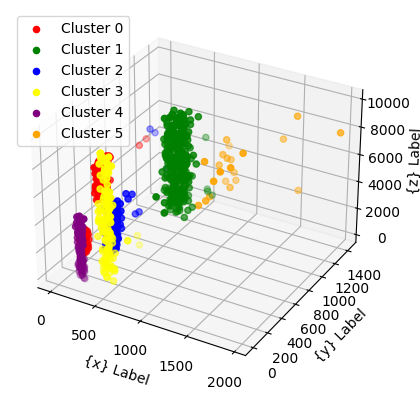

In [104]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

x = 'avg_weekly_volume_1'
y = 'avg_weekly_volume_0.2'
z = 'area(sqft)'

for i in range(6):
    cluster_data = outlets_data[outlets_data['cluster'] == i]
    ax.scatter(cluster_data[x], cluster_data[y], cluster_data[z], c=colors[i], label=f'Cluster {i}')

ax.set_xlabel('{x} Label')
ax.set_ylabel('{y} Label')
ax.set_zlabel('{z} Label')
plt.legend()
plt.show()

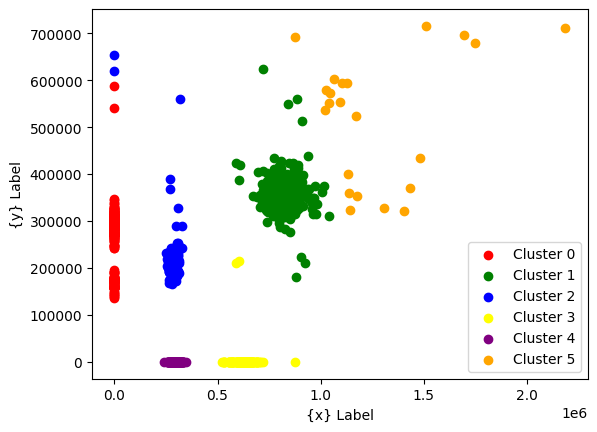

In [105]:
fig, ax = plt.subplots()

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

x = 'avg_weekly_income_1'
y = 'avg_weekly_income_0.2'

for i in range(6):
    cluster_data = outlets_data[outlets_data['cluster'] == i]
    ax.scatter(cluster_data[x], cluster_data[y], c=colors[i], label=f'Cluster {i}')

ax.set_xlabel('{x} Label')
ax.set_ylabel('{y} Label')
plt.legend()
plt.show()

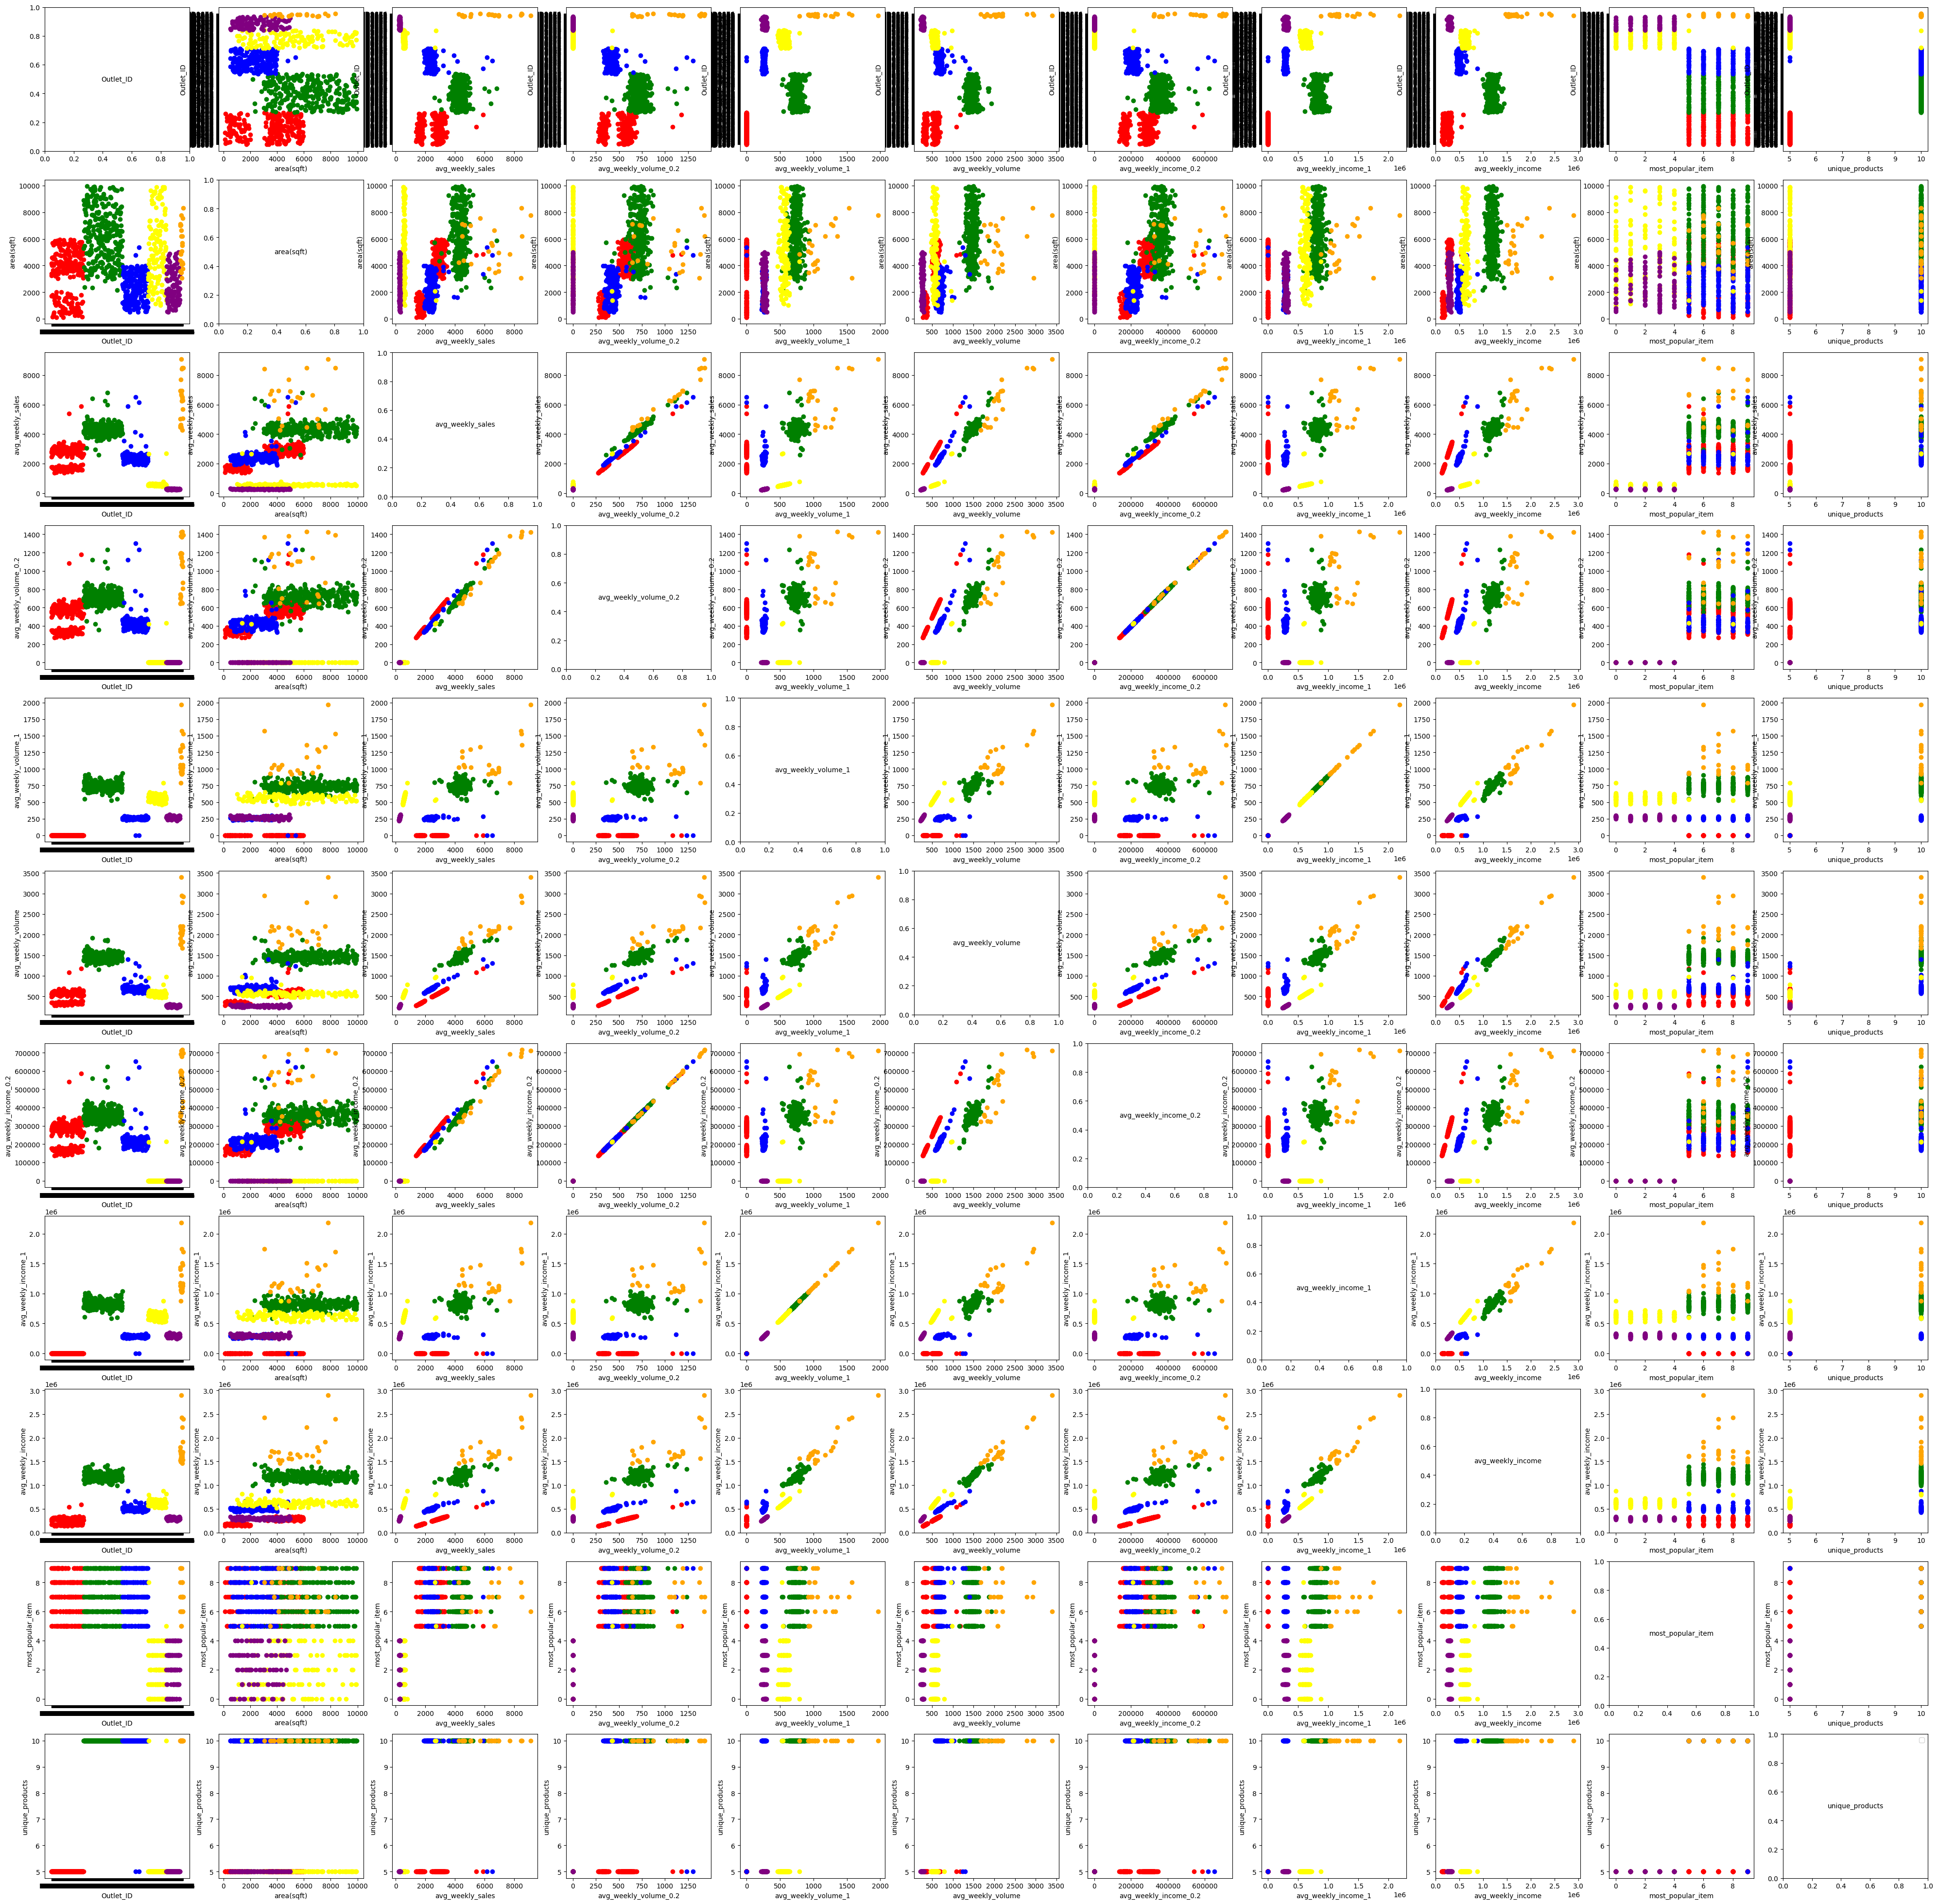

In [106]:

colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']
features = list(outlets_data.columns)
features.remove('cluster')

fig, axs = plt.subplots(len(features), len(features), figsize=(50, 50))

for i in range(len(features)):
    for j in range(len(features)):
        if i == j:
            axs[i, j].text(0.5, 0.5, features[i], ha='center', va='center')
        else:
            for k in range(6):
                cluster_data = outlets_data[outlets_data['cluster'] == k]
                axs[i, j].scatter(cluster_data[features[j]], cluster_data[features[i]], c=colors[k], label=f'Cluster {k}')
            axs[i, j].set_xlabel(features[j])
            axs[i, j].set_ylabel(features[i])

plt.legend()
plt.show()

In [107]:
sales_data.head()

,Outlet_ID,week,pid,product_name,no_units
0,ID7203,1,IP1,Vanilla Mini Cone,874.0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0


In [108]:
outlets_data.head()

,Outlet_ID,area(sqft),avg_weekly_sales,avg_weekly_volume_0.2,avg_weekly_volume_1,avg_weekly_volume,avg_weekly_income_0.2,avg_weekly_income_1,avg_weekly_income,most_popular_item,unique_products,cluster
0,ID1008,3387.0,2750.166667,550.033333,0.000000,550.033333,274249.166667,0.000000,2.742492e+05,6,5,0
1,ID1012,1931.0,272.916667,0.000000,272.916667,272.916667,0.000000,304054.166667,3.040542e+05,2,5,4
2,ID1024,3127.0,578.583333,0.000000,578.583333,578.583333,0.000000,643858.333333,6.438583e+05,0,5,3
3,ID1029,5294.0,4095.166667,679.666667,696.833333,1376.500000,341150.833333,775612.500000,1.116763e+06,5,10,1
4,ID1036,2584.0,2613.666667,470.050000,263.416667,733.466667,235435.000000,292804.166667,5.282392e+05,7,10,2


In [109]:
# assuming sales_data and outlets_data are already defined as pandas dataframes
sales_with_cluster = pd.merge(sales_data, outlets_data[['Outlet_ID', 'cluster']], on='Outlet_ID')

In [110]:
sales_with_cluster.head()

,Outlet_ID,week,pid,product_name,no_units,cluster
0,ID7203,1,IP1,Vanilla Mini Cone,874.0,0
1,ID7203,1,IP2,Chocolate Petite Bar,105.0,0
2,ID7203,1,IP3,Strawberry Tiny Cup,1198.0,0
3,ID7203,1,IP4,Mint Bite-size Pop,502.0,0
4,ID7203,1,IP5,Butter Pecan Small Stick,710.0,0


In [111]:
sales_by_cluster_pid = sales_with_cluster.groupby(['cluster', 'pid'])['no_units'].sum()

In [112]:
sales_by_cluster_pid.head()

cluster  pid
0        IP1    1449350.0
         IP2    1433002.0
         IP3    1439621.0
         IP4    1444910.0
         IP5    1418737.0
Name: no_units, dtype: float64

In [113]:
sales_by_cluster_pid = sales_by_cluster_pid.reset_index()

In [114]:
sales_by_cluster_pid.head()

,cluster,pid,no_units
0,0,IP1,1449350.0
1,0,IP2,1433002.0
2,0,IP3,1439621.0
3,0,IP4,1444910.0
4,0,IP5,1418737.0


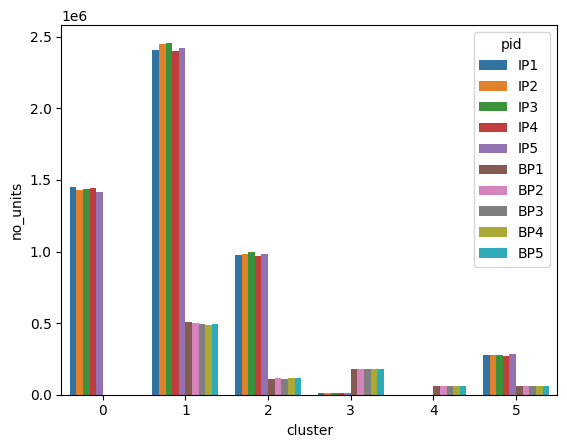

In [115]:
import seaborn as sns

# Create a barplot
sns.barplot(x='cluster', y='no_units', hue='pid', data=sales_by_cluster_pid)

# Show the plot
plt.show()

In [116]:
result = sales_by_cluster_pid.loc[sales_by_cluster_pid.groupby('cluster')['no_units'].idxmax()]

In [117]:
result

,cluster,pid,no_units
0,0,IP1,1449350.0
12,1,IP3,2458292.0
22,2,IP3,996448.0
25,3,BP1,180382.0
38,4,BP4,64393.0
49,5,IP5,282939.0


In [128]:
cluster_summary_num['cluster'] = cluster_summary_num.index
cluster_summary_num

,cluster,avg_weekly_income,avg_weekly_volume,ChillMaster,FreezeZone,CoolTech,mini CoolTech,IceBlast Pro,IceBlast,FreezeTech,FreezeTech 3.0,ChillTech,IceTech
0,0,2.570211e+05,514.992847,10.0,7.0,5.0,18.0,4.0,8.0,6.0,21.0,7.0,3.0
1,1,1.184135e+06,1464.227679,27.0,20.0,13.0,49.0,10.0,23.0,15.0,59.0,19.0,8.0
2,2,5.048540e+05,698.745495,13.0,10.0,6.0,24.0,5.0,11.0,7.0,28.0,9.0,4.0
3,3,6.283295e+05,570.481187,11.0,8.0,5.0,19.0,4.0,9.0,6.0,23.0,8.0,3.0
4,4,2.964486e+05,268.188552,5.0,4.0,3.0,9.0,2.0,5.0,3.0,11.0,4.0,2.0
5,5,1.791520e+06,2189.396970,40.0,30.0,19.0,73.0,15.0,34.0,22.0,88.0,28.0,11.0


In [129]:
# assuming new_dataframe is already defined
freezer_columns = ['ChillMaster', 'FreezeZone', 'CoolTech', 'mini CoolTech', 'IceBlast Pro', 'IceBlast', 'FreezeTech', 'FreezeTech 3.0', 'ChillTech', 'IceTech']
new_dataframe['freezertype'] = new_dataframe[freezer_columns].idxmax(axis=1)
result = new_dataframe[['cluster', 'avg_weekly_volume', 'freezertype']]

KeyError: "['FreezeTech'] not in index"

In [162]:
data = {'cluster': [0, 1, 2, 3, 4, 5],
        'freezertype': ['IceTech', 'IceBlast Pro', 'IceTech', 'IceTech', 'IceBlast Pro', 'IceBlast Pro']}

cluster_allocate = pd.DataFrame(data)

In [163]:
cluster_allocate

,cluster,freezertype
0,0,IceTech
1,1,IceBlast Pro
2,2,IceTech
3,3,IceTech
4,4,IceBlast Pro
5,5,IceBlast Pro


In [164]:
# assuming cluster_allocate and cluster_summary_num are already defined
cluster_allocate = pd.merge(cluster_allocate, cluster_summary_num[['cluster', 'avg_weekly_volume']], on='cluster', how='left')
cluster_allocate['number_of_freezers'] = cluster_allocate.apply(lambda row: cluster_summary_num.loc[cluster_summary_num['cluster'] == row['cluster'], row['freezertype']].values[0], axis=1)

In [185]:
freezer_data


,Freezer Name,Model Number,Volume Capacity (Liters),Power and maitainance Cost (LKR) per 100 hours
0,ChillMaster,M001,55,2500
1,FreezeZone,M002,75,2800
2,CoolTech,M003,120,3200
3,mini CoolTech,M004,30,1800
4,IceBlast Pro,M005,150,3500
5,IceBlast,M006,65,2700
6,FreezeTech,M007,100,3000
7,FreezeTech 3.0,M008,25,1600
8,ChillTech,M009,80,2800
9,IceTech,M010,200,4500


In [197]:
cluster_allocate

,cluster,freezertype,avg_weekly_volume,number_of_freezers,total_freezer_volume
0,0,IceTech,514.992847,3.0,600.0
1,1,IceBlast Pro,1464.227679,10.0,1500.0
2,2,IceTech,698.745495,4.0,800.0
3,3,IceTech,570.481187,3.0,600.0
4,4,IceBlast Pro,268.188552,2.0,300.0
5,5,IceBlast Pro,2189.396970,15.0,2250.0


In [187]:
# Assuming you have the dataframes cluster_allocate and freezer_data
# Calculate the total volume for each freezer type
total_volume = freezer_data.groupby('Freezer Name')['Volume Capacity (Liters)'].sum().reset_index()
total_volume.columns = ['freezertype', 'total_volume']

# Merge the dataframes to add the total volume to the cluster_allocate dataframe
cluster_allocate = pd.merge(cluster_allocate, total_volume, on='freezertype', how='left')

In [188]:
total_volume

,freezertype,total_volume
0,ChillMaster,55
1,ChillTech,80
2,CoolTech,120
3,FreezeTech,100
4,FreezeTech 3.0,25
5,FreezeZone,75
6,IceBlast,65
7,IceBlast Pro,150
8,IceTech,200
9,mini CoolTech,30


In [166]:
product_data.head()

,pid,volume,product_name,price,cost,stock
0,IP3,0.2,Strawberry Tiny Cup,110,98.45,225000
1,IP2,0.2,Chocolate Petite Bar,90,79.2,75000
2,IP1,0.2,Vanilla Mini Cone,100,89,120000
3,IP5,0.2,Butter Pecan Small Stick,100,88.5,150000
4,IP4,0.2,Mint Bite-size Pop,100,89.5,200000


In [167]:
# assuming the original DataFrame is called products
updated_products = product_data.copy()
updated_products['total_volume'] = updated_products['stock'] * updated_products['volume']

In [168]:
updated_products

,pid,volume,product_name,price,cost,stock,total_volume
0,IP3,0.2,Strawberry Tiny Cup,110,98.45,225000,45000.0
1,IP2,0.2,Chocolate Petite Bar,90,79.2,75000,15000.0
2,IP1,0.2,Vanilla Mini Cone,100,89,120000,24000.0
3,IP5,0.2,Butter Pecan Small Stick,100,88.5,150000,30000.0
4,IP4,0.2,Mint Bite-size Pop,100,89.5,200000,40000.0
5,BP2,1.0,Moose Tracks Jumbo Cup,1100,924,8000,8000.0
6,BP1,1.0,Chocolate Fudge Big Scoop,1200,"1,020.00",10000,10000.0
7,BP5,1.0,Cookies and Cream Mega Tub,1100,918.5,4000,4000.0
8,BP3,1.0,Mint Chocolate Chip Family Pack,1150,966,9000,9000.0
9,BP4,1.0,Rocky Road Mega Tub,1000,820,5000,5000.0


In [169]:
# assuming the DataFrame is called updated_products
updated_products[' cost '] = updated_products[' cost '].str.replace(',', '').astype(float)
updated_products['price'] = updated_products['price'].astype(int)
print(updated_products.columns)

Index(['pid', 'volume', 'product_name', 'price', ' cost ', 'stock',
       'total_volume'],
      dtype='object')


In [170]:
# assuming the DataFrame is called products
updated_products['margin'] = updated_products['price'] - updated_products[' cost ']

In [171]:
updated_products

,pid,volume,product_name,price,cost,stock,total_volume,margin
0,IP3,0.2,Strawberry Tiny Cup,110,98.45,225000,45000.0,11.55
1,IP2,0.2,Chocolate Petite Bar,90,79.20,75000,15000.0,10.80
2,IP1,0.2,Vanilla Mini Cone,100,89.00,120000,24000.0,11.00
3,IP5,0.2,Butter Pecan Small Stick,100,88.50,150000,30000.0,11.50
4,IP4,0.2,Mint Bite-size Pop,100,89.50,200000,40000.0,10.50
5,BP2,1.0,Moose Tracks Jumbo Cup,1100,924.00,8000,8000.0,176.00
6,BP1,1.0,Chocolate Fudge Big Scoop,1200,1020.00,10000,10000.0,180.00
7,BP5,1.0,Cookies and Cream Mega Tub,1100,918.50,4000,4000.0,181.50
8,BP3,1.0,Mint Chocolate Chip Family Pack,1150,966.00,9000,9000.0,184.00
9,BP4,1.0,Rocky Road Mega Tub,1000,820.00,5000,5000.0,180.00


In [173]:
clusters = outlets_data[['Outlet_ID', 'cluster']]

In [200]:
merged_df = pd.merge(sales_data, clusters, on='Outlet_ID', how='left')
product_distribution = merged_df.groupby(['cluster', 'product_name'])['no_units'].sum().reset_index()
product_distribution.pivot(index='cluster', columns='product_name', values='no_units')

product_name,Butter Pecan Small Stick,Chocolate Fudge Big Scoop,Chocolate Petite Bar,Cookies and Cream Mega Tub,Mint Bite-size Pop,Mint Chocolate Chip Family Pack,Moose Tracks Jumbo Cup,Rocky Road Mega Tub,Strawberry Tiny Cup,Vanilla Mini Cone
cluster,,,,,,,,,,
0,1418737.0,NaN,1433002.0,NaN,1444910.0,NaN,NaN,NaN,1439621.0,1449350.0
1,2422828.0,504680.0,2446868.0,496917.0,2398456.0,497103.0,503247.0,487723.0,2458292.0,2407431.0
2,979544.0,111946.0,985752.0,113548.0,968916.0,113061.0,115650.0,113597.0,996448.0,975305.0
3,8964.0,180382.0,10680.0,178626.0,10690.0,177539.0,177781.0,177485.0,9566.0,11326.0
4,NaN,62612.0,NaN,63372.0,NaN,63916.0,63127.0,64393.0,NaN,NaN
5,282939.0,60962.0,277614.0,59914.0,267023.0,58204.0,62499.0,60283.0,277339.0,274459.0


In [203]:
product_distribution_weekly = product_distribution.copy()

In [205]:
product_distribution_weekly['no_units'] = product_distribution_weekly['no_units'] / 12

In [206]:
product_distribution_weekly

,cluster,product_name,no_units
0,0,Butter Pecan Small Stick,118228.083333
1,0,Chocolate Petite Bar,119416.833333
2,0,Mint Bite-size Pop,120409.166667
3,0,Strawberry Tiny Cup,119968.416667
4,0,Vanilla Mini Cone,120779.166667
5,1,Butter Pecan Small Stick,201902.333333
6,1,Chocolate Fudge Big Scoop,42056.666667
7,1,Chocolate Petite Bar,203905.666667
8,1,Cookies and Cream Mega Tub,41409.750000
9,1,Mint Bite-size Pop,199871.333333


In [180]:
# Assuming you have the dataframes product_distribution, updated_products and cluster_allocate
# Merge the dataframes to get the required information in one dataframe
merged_df = pd.merge(product_distribution, updated_products, left_on='product_name', right_on='product_name')
merged_df = pd.merge(merged_df, cluster_allocate, left_on='cluster', right_on='cluster')

# # Calculate the allocated volume for each product
# merged_df['allocated_volume'] = merged_df['avg_weekly_volume'] * 0.3

# # Create a new dataframe with the required columns
# new_df = merged_df[['cluster', 'freezertype', 'number_of_freezers', 'pid', 'product_name', 'allocated_volume']]
# new_df.columns = ['Cluster', 'Freezer Type', 'Freezer Volume', 'Product ID', 'Product Name', 'Allocated Volume in L']

# Sort the dataframe by margin to get the products with highest margin first
# new_df = new_df.sort_values(by='margin', ascending=False)

# Keep only the rows where the allocated volume is less than or equal to 30% of the total volume
new_df = new_df[new_df['Allocated Volume in L'] <= new_df['Freezer Volume'] * 0.3]

In [181]:
merged_df

,cluster,product_name,no_units,pid,volume,price,cost,stock,total_volume,margin,freezertype,avg_weekly_volume,number_of_freezers
0,0,Butter Pecan Small Stick,1418737.0,IP5,0.2,100,88.50,150000,30000.0,11.50,IceTech,514.992847,3.0
1,0,Chocolate Petite Bar,1433002.0,IP2,0.2,90,79.20,75000,15000.0,10.80,IceTech,514.992847,3.0
2,0,Mint Bite-size Pop,1444910.0,IP4,0.2,100,89.50,200000,40000.0,10.50,IceTech,514.992847,3.0
3,0,Strawberry Tiny Cup,1439621.0,IP3,0.2,110,98.45,225000,45000.0,11.55,IceTech,514.992847,3.0
4,0,Vanilla Mini Cone,1449350.0,IP1,0.2,100,89.00,120000,24000.0,11.00,IceTech,514.992847,3.0
5,1,Butter Pecan Small Stick,2422828.0,IP5,0.2,100,88.50,150000,30000.0,11.50,IceBlast Pro,1464.227679,10.0
6,1,Chocolate Petite Bar,2446868.0,IP2,0.2,90,79.20,75000,15000.0,10.80,IceBlast Pro,1464.227679,10.0
7,1,Mint Bite-size Pop,2398456.0,IP4,0.2,100,89.50,200000,40000.0,10.50,IceBlast Pro,1464.227679,10.0
8,1,Strawberry Tiny Cup,2458292.0,IP3,0.2,110,98.45,225000,45000.0,11.55,IceBlast Pro,1464.227679,10.0
9,1,Vanilla Mini Cone,2407431.0,IP1,0.2,100,89.00,120000,24000.0,11.00,IceBlast Pro,1464.227679,10.0


In [207]:
updated_products

,pid,volume,product_name,price,cost,stock,total_volume,margin
0,IP3,0.2,Strawberry Tiny Cup,110,98.45,225000,45000.0,11.55
1,IP2,0.2,Chocolate Petite Bar,90,79.20,75000,15000.0,10.80
2,IP1,0.2,Vanilla Mini Cone,100,89.00,120000,24000.0,11.00
3,IP5,0.2,Butter Pecan Small Stick,100,88.50,150000,30000.0,11.50
4,IP4,0.2,Mint Bite-size Pop,100,89.50,200000,40000.0,10.50
5,BP2,1.0,Moose Tracks Jumbo Cup,1100,924.00,8000,8000.0,176.00
6,BP1,1.0,Chocolate Fudge Big Scoop,1200,1020.00,10000,10000.0,180.00
7,BP5,1.0,Cookies and Cream Mega Tub,1100,918.50,4000,4000.0,181.50
8,BP3,1.0,Mint Chocolate Chip Family Pack,1150,966.00,9000,9000.0,184.00
9,BP4,1.0,Rocky Road Mega Tub,1000,820.00,5000,5000.0,180.00


In [208]:
cluster_allocate

,cluster,freezertype,avg_weekly_volume,number_of_freezers,total_freezer_volume
0,0,IceTech,514.992847,3.0,600.0
1,1,IceBlast Pro,1464.227679,10.0,1500.0
2,2,IceTech,698.745495,4.0,800.0
3,3,IceTech,570.481187,3.0,600.0
4,4,IceBlast Pro,268.188552,2.0,300.0
5,5,IceBlast Pro,2189.396970,15.0,2250.0


In [211]:
product_distribution_weekly['no_units'] = product_distribution_weekly['no_units'].astype(int)

In [213]:
product_distribution_weekly

,cluster,product_name,no_units
0,0,Butter Pecan Small Stick,118228
1,0,Chocolate Petite Bar,119416
2,0,Mint Bite-size Pop,120409
3,0,Strawberry Tiny Cup,119968
4,0,Vanilla Mini Cone,120779
5,1,Butter Pecan Small Stick,201902
6,1,Chocolate Fudge Big Scoop,42056
7,1,Chocolate Petite Bar,203905
8,1,Cookies and Cream Mega Tub,41409
9,1,Mint Bite-size Pop,199871


In [214]:
# Assuming you have the dataframes updated_products and product_distribution_weekly
# Merge the dataframes to get the required information in one dataframe
merged_df = pd.merge(updated_products, product_distribution_weekly, on='product_name')

# Calculate the total product volume and total margin
merged_df['total_product_volume'] = merged_df['no_units'] * merged_df['volume']
merged_df['total_margin'] = merged_df['no_units'] * merged_df['margin']

# Add the calculated columns to the product_distribution_weekly dataframe
product_distribution_weekly['total_product_volume'] = merged_df['total_product_volume']
product_distribution_weekly['total_margin'] = merged_df['total_margin']

In [215]:
product_distribution_weekly

,cluster,product_name,no_units,total_product_volume,total_margin
0,0,Butter Pecan Small Stick,118228,23993.6,1385630.40
1,0,Chocolate Petite Bar,119416,40971.4,2366098.35
2,0,Mint Bite-size Pop,120409,16607.4,959077.35
3,0,Strawberry Tiny Cup,119968,159.4,9205.35
4,0,Vanilla Mini Cone,120779,4622.2,266932.05
5,1,Butter Pecan Small Stick,201902,23883.2,1289692.80
6,1,Chocolate Fudge Big Scoop,42056,40781.0,2202174.00
7,1,Chocolate Petite Bar,203905,16429.2,887176.80
8,1,Cookies and Cream Mega Tub,41409,178.0,9612.00
9,1,Mint Bite-size Pop,199871,4626.8,249847.20


In [218]:
clusters.head()

,Outlet_ID,cluster
0,ID1008,0
1,ID1012,4
2,ID1024,3
3,ID1029,1
4,ID1036,2


In [219]:
# Assuming you have the dataframe clusters
# Group the dataframe by cluster and count the number of outlets in each cluster
outlet_count = clusters.groupby('cluster')['Outlet_ID'].count().reset_index()
outlet_count.columns = ['Cluster', 'Number of Outlets']

In [221]:
outlet_count

,Cluster,Number of Outlets
0,0,233
1,1,280
2,2,185
3,3,132
4,4,99
5,5,22


In [250]:
# Assuming you have the dataframes outlet_count and cluster_allocate
# Merge the dataframes on the cluster column
merged_df = pd.merge(outlet_count, cluster_allocate, left_on='Cluster', right_on='cluster')

In [252]:
merged_df.drop(['cluster'], axis=1)

,Cluster,Number of Outlets,freezertype,avg_weekly_volume,number_of_freezers,total_freezer_volume,total_volume
0,0,233,IceTech,514.992847,3.0,600.0,139800.0
1,1,280,IceBlast Pro,1464.227679,10.0,1500.0,420000.0
2,2,185,IceTech,698.745495,4.0,800.0,148000.0
3,3,132,IceTech,570.481187,3.0,600.0,79200.0
4,4,99,IceBlast Pro,268.188552,2.0,300.0,29700.0
5,5,22,IceBlast Pro,2189.396970,15.0,2250.0,49500.0


In [251]:
merged_df['total_volume'] = merged_df['Number of Outlets'] * merged_df['total_freezer_volume']

In [228]:
merged_df =merged_df.drop(['cluster'], axis=1)

In [233]:
merged_df['cluster'] = merged_df['Cluster']

In [235]:
merged_df = merged_df.drop(['Cluster'], axis=1)

In [230]:
product_distribution_weekly

,cluster,product_name,no_units,total_product_volume,total_margin
0,0,Butter Pecan Small Stick,118228,23993.6,1385630.40
1,0,Chocolate Petite Bar,119416,40971.4,2366098.35
2,0,Mint Bite-size Pop,120409,16607.4,959077.35
3,0,Strawberry Tiny Cup,119968,159.4,9205.35
4,0,Vanilla Mini Cone,120779,4622.2,266932.05
5,1,Butter Pecan Small Stick,201902,23883.2,1289692.80
6,1,Chocolate Fudge Big Scoop,42056,40781.0,2202174.00
7,1,Chocolate Petite Bar,203905,16429.2,887176.80
8,1,Cookies and Cream Mega Tub,41409,178.0,9612.00
9,1,Mint Bite-size Pop,199871,4626.8,249847.20


In [236]:

# Merge the two dataframes on the cluster column
merged_df = merged_df.merge(product_distribution_weekly, on='cluster')

# Sort the merged dataframe by cluster and total_margin in descending order
merged_df = merged_df.sort_values(['cluster', 'total_margin'], ascending=[True, False])

# Create a new dataframe to store the optimized results
optimized_df = pd.DataFrame(columns=merged_df.columns)

# Iterate over each cluster
for cluster in merged_df['cluster'].unique():
    # Get the data for the current cluster
    cluster_data = merged_df[merged_df['cluster'] == cluster]
    
    # Calculate the maximum allowed volume for a single product (30% of the recommended freezer type's volume)
    max_volume = 0.3 * cluster_data['total_volume'].iloc[0]
    
    # Initialize variables to track the allocated volume and total margin
    allocated_volume = 0
    total_margin = 0
    
    # Iterate over each row in the cluster data
    for _, row in cluster_data.iterrows():
        # Check if adding the current product's volume exceeds the maximum allowed volume
        if allocated_volume + row['total_product_volume'] <= max_volume:
            # Add the product to the optimized dataframe
            optimized_df = optimized_df.append(row)
            
            # Update the allocated volume and total margin
            allocated_volume += row['total_product_volume']
            total_margin += row['total_margin']
    
    # Print the optimized results for the current cluster
    print(f"Cluster {cluster}: Allocated Volume = {allocated_volume}, Total Margin = {total_margin}")

# Reset the index of the optimized dataframe
optimized_df = optimized_df.reset_index(drop=True)

# Print the optimized dataframe
print("\nOptimized Freezer Assortment and Volume Allocation:")
print(optimized_df)


Cluster 0: Allocated Volume = 41130.8, Total Margin = 2375303.6999999997
Cluster 1: Allocated Volume = 125889.8, Total Margin = 6883158.0
Cluster 2: Allocated Volume = 40707.8, Total Margin = 2339808.5
Cluster 3: Allocated Volume = 20248.0, Total Margin = 3644640.0
Cluster 4: Allocated Volume = 5281.0, Total Margin = 958501.5
Cluster 5: Allocated Volume = 14794.0, Total Margin = 2722096.0

Optimized Freezer Assortment and Volume Allocation:
   Number of Outlets   freezertype  avg_weekly_volume  number_of_freezers  \
0                233       IceTech         514.992847                 3.0   
1                233       IceTech         514.992847                 3.0   
2                280  IceBlast Pro        1464.227679                10.0   
3                280  IceBlast Pro        1464.227679                10.0   
4                280  IceBlast Pro        1464.227679                10.0   
5                280  IceBlast Pro        1464.227679                10.0   
6               

/tmp/ipykernel_34/3325970063.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimized_df = optimized_df.append(row)
/tmp/ipykernel_34/3325970063.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimized_df = optimized_df.append(row)
/tmp/ipykernel_34/3325970063.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimized_df = optimized_df.append(row)
/tmp/ipykernel_34/3325970063.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  optimized_df = optimized_df.append(row)
/tmp/ipykernel_34/3325970063.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [237]:
optimized_df

,Number of Outlets,freezertype,avg_weekly_volume,number_of_freezers,total_freezer_volume,total_volume,cluster,product_name,no_units,total_product_volume,total_margin
0,233,IceTech,514.992847,3.0,600.0,139800.0,0,Chocolate Petite Bar,119416,40971.4,2366098.35
1,233,IceTech,514.992847,3.0,600.0,139800.0,0,Strawberry Tiny Cup,119968,159.4,9205.35
2,280,IceBlast Pro,1464.227679,10.0,1500.0,420000.0,1,Moose Tracks Jumbo Cup,41937,40123.8,2206809.00
3,280,IceBlast Pro,1464.227679,10.0,1500.0,420000.0,1,Chocolate Fudge Big Scoop,42056,40781.0,2202174.00
4,280,IceBlast Pro,1464.227679,10.0,1500.0,420000.0,1,Mint Chocolate Chip Family Pack,41425,24155.8,1328569.00
5,280,IceBlast Pro,1464.227679,10.0,1500.0,420000.0,1,Rocky Road Mega Tub,40643,16255.0,894025.00
6,280,IceBlast Pro,1464.227679,10.0,1500.0,420000.0,1,Vanilla Mini Cone,200619,4574.2,251581.00
7,185,IceTech,698.745495,4.0,800.0,148000.0,2,Chocolate Fudge Big Scoop,9328,40380.4,2321873.00
8,185,IceTech,698.745495,4.0,800.0,148000.0,2,Strawberry Tiny Cup,83037,178.0,9345.00
9,185,IceTech,698.745495,4.0,800.0,148000.0,2,Cookies and Cream Mega Tub,9462,149.4,8590.50


In [240]:

# Assuming merged_df and product_distribution_weekly dataframes are already given

# Create a dictionary to store the maximum volume for each cluster
max_volume = merged_df.set_index('cluster')['total_freezer_volume'].to_dict()

# Create a dictionary to store the available stock for each product
available_stock = product_distribution_weekly.groupby('product_name')['no_units'].sum().to_dict()

# Define a function to calculate the total margin for a given cluster and product
def calc_total_margin(cluster, product):
    # Get the total margin for the given cluster and product
    total_margin = product_distribution_weekly[(product_distribution_weekly['cluster'] == cluster) & (product_distribution_weekly['product_name'] == product)]['total_margin'].sum()
    return total_margin

# Define a function to calculate the total volume for a given cluster and product
def calc_total_volume(cluster, product):
    # Get the total volume for the given cluster and product
    total_volume = product_distribution_weekly[(product_distribution_weekly['cluster'] == cluster) & (product_distribution_weekly['product_name'] == product)]['total_product_volume'].sum()
    return total_volume

# Define a function to optimize the freezer assortment and volume allocation for a given cluster
def optimize_freezer(cluster):
    # Get the maximum volume for the given cluster
    max_vol = max_volume[cluster]
    
    # Get the top-selling product for the given cluster
    top_product = product_distribution_weekly[product_distribution_weekly['cluster'] == cluster].sort_values('no_units', ascending=False).iloc[0]['product_name']
    
    # Initialize a list to store the selected products
    selected_products = [top_product]
    
    # Initialize a variable to store the remaining volume
    remaining_volume = max_vol - calc_total_volume(cluster, top_product)
    
    # Initialize a variable to store the total margin
    total_margin = calc_total_margin(cluster, top_product)
    
    # Loop through all products in the given cluster
    for product in product_distribution_weekly[product_distribution_weekly['cluster'] == cluster]['product_name'].unique():
        # Skip the top-selling product
        if product == top_product:
            continue
        
        # Calculate the total volume for the current product
        total_volume = calc_total_volume(cluster, product)
        
        # Check if adding the current product would exceed the maximum volume or available stock
        if (remaining_volume - total_volume >= 0) and (available_stock[product] - total_volume >= 0):
            # Add the current product to the selected products
            selected_products.append(product)
            
            # Update the remaining volume and total margin
            remaining_volume -= total_volume
            total_margin += calc_total_margin(cluster, product)
            
            # Update the available stock for the current product
            available_stock[product] -= total_volume
    
    return selected_products, total_margin

# Optimize freezer assortment and volume allocation for all clusters
results = {}
for cluster in merged_df['cluster'].unique():
    selected_products, total_margin = optimize_freezer(cluster)
    results[cluster] = {'selected_products': selected_products, 'total_margin': total_margin}

# Convert results to a dataframe
results_df = pd.DataFrame(results).T

# Display results
print(results_df)


                                   selected_products total_margin
0                                [Vanilla Mini Cone]    266932.05
1  [Strawberry Tiny Cup, Cookies and Cream Mega Tub]      19985.0
2  [Strawberry Tiny Cup, Cookies and Cream Mega Tub]      17935.5
3                        [Chocolate Fudge Big Scoop]    1696112.0
4                              [Rocky Road Mega Tub]     906048.0
5                         [Butter Pecan Small Stick]    7622200.0


In [248]:
cluster_allocate = cluster_allocate.drop(['total_volume'],axis=1)
cluster_allocate['total_volume'] = cluster_allocate['number_of_freezers'] * cluster_allocate['total_freezer_volume']

In [253]:
cluster_allocate = merged_df.copy()

In [254]:
cluster_allocate

,Cluster,Number of Outlets,cluster,freezertype,avg_weekly_volume,number_of_freezers,total_freezer_volume,total_volume
0,0,233,0,IceTech,514.992847,3.0,600.0,139800.0
1,1,280,1,IceBlast Pro,1464.227679,10.0,1500.0,420000.0
2,2,185,2,IceTech,698.745495,4.0,800.0,148000.0
3,3,132,3,IceTech,570.481187,3.0,600.0,79200.0
4,4,99,4,IceBlast Pro,268.188552,2.0,300.0,29700.0
5,5,22,5,IceBlast Pro,2189.396970,15.0,2250.0,49500.0


We analyze the hitorical data and total margin on hitorical data based on clusters.

In [247]:
product_distribution_weekly

,cluster,product_name,no_units,total_product_volume,total_margin
0,0,Butter Pecan Small Stick,118228,23993.6,1385630.40
1,0,Chocolate Petite Bar,119416,40971.4,2366098.35
2,0,Mint Bite-size Pop,120409,16607.4,959077.35
3,0,Strawberry Tiny Cup,119968,159.4,9205.35
4,0,Vanilla Mini Cone,120779,4622.2,266932.05
5,1,Butter Pecan Small Stick,201902,23883.2,1289692.80
6,1,Chocolate Fudge Big Scoop,42056,40781.0,2202174.00
7,1,Chocolate Petite Bar,203905,16429.2,887176.80
8,1,Cookies and Cream Mega Tub,41409,178.0,9612.00
9,1,Mint Bite-size Pop,199871,4626.8,249847.20


In [255]:
product_distribution_weekly.groupby('cluster')['total_product_volume'].sum()

cluster
0     86354.0
1    171195.6
2    170049.4
3    153569.0
4     76029.0
5    151104.0
Name: total_product_volume, dtype: float64

In [ ]:

# Step 1: Calculate total margin for each product
product_distribution_weekly['total_margin'] = product_distribution_weekly['no_units'] * product_distribution_weekly['total_margin']

# Step 2: Sort products within each cluster by total margin
product_distribution_weekly = product_distribution_weekly.sort_values(['cluster', 'total_margin'], ascending=[True, False])

# Step 3-5: Iterate over clusters, select top-selling products, assign allocated volume
final_output = pd.DataFrame(columns=['cluster', 'Recommended Freezer type', 'Freezer Volume', 'Product ID', 'Product Name', 'Allocated Volume in L'])

for cluster in merged_df['cluster'].unique():
    cluster_data = merged_df[merged_df['cluster'] == cluster]
    freezer_type = cluster_data['freezertype'].iloc[0]
    freezer_volume = cluster_data['total_freezer_volume'].iloc[0]
    
    product_data = product_distribution_weekly[product_distribution_weekly['cluster'] == cluster]
    
    allocated_volume = 0
    selected_products = []
    
    for _, product in product_data.iterrows():
        if allocated_volume + product['total_product_volume'] <= freezer_volume * 0.3:
            allocated_volume += product['total_product_volume']
            selected_products.append((product['Product ID'], product['Product Name'], product['total_product_volume']))
    
    for product in selected_products:
        final_output = final_output.append({
            'cluster': cluster,
            'Recommended Freezer type': freezer_type,
            'Freezer Volume': freezer_volume,
            'Product ID': product[0],
            'Product Name': product[1],
            'Allocated Volume in L': product[2]
        }, ignore_index=True)

# Display the final output
print(final_output)


In [256]:
product_data.head()

,pid,volume,product_name,price,cost,stock
0,IP3,0.2,Strawberry Tiny Cup,110,98.45,225000
1,IP2,0.2,Chocolate Petite Bar,90,79.2,75000
2,IP1,0.2,Vanilla Mini Cone,100,89,120000
3,IP5,0.2,Butter Pecan Small Stick,100,88.5,150000
4,IP4,0.2,Mint Bite-size Pop,100,89.5,200000


In [259]:
product_data['total_volume'] = product_data['volume'] * product_data['stock']
product_data[' cost '] = product_data[' cost '].str.replace(',', '').astype(float)
product_data['margin'] = product_data['price'] - product_data[' cost ']

Calculated product total colume and margin.

In [260]:
product_data

,pid,volume,product_name,price,cost,stock,total_volume,margin
0,IP3,0.2,Strawberry Tiny Cup,110,98.45,225000,45000.0,11.55
1,IP2,0.2,Chocolate Petite Bar,90,79.20,75000,15000.0,10.80
2,IP1,0.2,Vanilla Mini Cone,100,89.00,120000,24000.0,11.00
3,IP5,0.2,Butter Pecan Small Stick,100,88.50,150000,30000.0,11.50
4,IP4,0.2,Mint Bite-size Pop,100,89.50,200000,40000.0,10.50
5,BP2,1.0,Moose Tracks Jumbo Cup,1100,924.00,8000,8000.0,176.00
6,BP1,1.0,Chocolate Fudge Big Scoop,1200,1020.00,10000,10000.0,180.00
7,BP5,1.0,Cookies and Cream Mega Tub,1100,918.50,4000,4000.0,181.50
8,BP3,1.0,Mint Chocolate Chip Family Pack,1150,966.00,9000,9000.0,184.00
9,BP4,1.0,Rocky Road Mega Tub,1000,820.00,5000,5000.0,180.00
